In [ ]:
import os
import zipfile
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

In [ ]:
import os
import zipfile
import random
import shutil

# Define paths
zip_path = "/content/archive (1).zip"  # Change this to your ZIP file name
extract_path = "dataset"  # Folder where extracted files will go
train_dir = os.path.join(extract_path, "train")
test_dir = os.path.join(extract_path, "test")

# Step 1: Extract dataset if not already extracted
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset extracted successfully!")
else:
    print("Dataset already extracted.")

Dataset extracted successfully!


In [ ]:
import os

extract_path = "dataset"  # This should be the folder containing waste categories
for root, dirs, files in os.walk(extract_path):
    print(root, "->", dirs)

dataset -> ['dataset-resized']
dataset/dataset-resized -> ['paper', 'glass', 'metal', 'plastic', 'trash', 'cardboard']
dataset/dataset-resized/paper -> []
dataset/dataset-resized/glass -> []
dataset/dataset-resized/metal -> []
dataset/dataset-resized/plastic -> []
dataset/dataset-resized/trash -> []
dataset/dataset-resized/cardboard -> []


In [ ]:
# Define correct dataset directory
base_dir = "/content/dataset/dataset-resized"  # Change this based on Step 1 output

# New paths
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Ensure train and test directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get only actual category folders (not 'train' or 'test')
categories = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d)) and d not in ["train", "test"]]

split_ratio = 0.8  # 80% train, 20% test

for category in categories:
    category_path = os.path.join(base_dir, category)
    images = [img for img in os.listdir(category_path) if img.endswith(('.jpg', '.png', '.jpeg'))]  # Get only images

    random.shuffle(images)
    split_idx = int(len(images) * split_ratio)

    train_images = images[:split_idx]
    test_images = images[split_idx:]

    # Create category folders inside train & test
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

    # Move images to train/test
    for img in train_images:
        shutil.move(os.path.join(category_path, img), os.path.join(train_dir, category, img))
    for img in test_images:
        shutil.move(os.path.join(category_path, img), os.path.join(test_dir, category, img))

    print(f"Category '{category}': {len(train_images)} train, {len(test_images)} test")

print("✅ Dataset splitting completed successfully!")

Category 'paper': 475 train, 119 test
Category 'glass': 400 train, 101 test
Category 'metal': 328 train, 82 test
Category 'plastic': 385 train, 97 test
Category 'trash': 109 train, 28 test
Category 'cardboard': 322 train, 81 test
✅ Dataset splitting completed successfully!


In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [ ]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Load dataset
train_data = datasets.ImageFolder(root=train_dir, transform=transform)
test_data = datasets.ImageFolder(root=test_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Training Images: {len(train_data)} | Testing Images: {len(test_data)}")

Training Images: 2019 | Testing Images: 508


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

class RWCNet(nn.Module):
    def __init__(self):
        super(RWCNet, self).__init__()
        self.densenet = models.densenet201(pretrained=True)
        self.mobilenet = models.mobilenet_v2(pretrained=True)

        # Remove the final classification layers
        self.densenet.classifier = nn.Identity()
        self.mobilenet.classifier = nn.Identity()

        # Fully connected layer for classification
        self.fc = nn.Sequential(
            nn.Linear(1920 + 1280, 512),  # 1920 from DenseNet, 1280 from MobileNet
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 6),  # 6 Classes (cardboard, glass, metal, paper, plastic, litter)
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x1 = self.densenet(x)
        x2 = self.mobilenet(x)
        x_combined = torch.cat((x1, x2), dim=1)
        return self.fc(x_combined)

# Initialize Model
model = RWCNet().to('cuda' if torch.cuda.is_available() else 'cpu')
print("✅ Model Loaded Successfully!")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 162MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may 

✅ Model Loaded Successfully!


In [ ]:
import torch
import torchvision.models as models

# Load models
densenet = models.densenet201(pretrained=True)
mobilenet = models.mobilenet_v2(pretrained=True)

# Create a dummy input
dummy_input = torch.randn(1, 3, 224, 224)  # Batch size 1, 3 color channels, 224x224 image

# Remove classifier layers to check feature sizes
densenet_features = densenet.features(dummy_input)
mobilenet_features = mobilenet.features(dummy_input)

# Print shapes before flattening
print("DenseNet Features Shape:", densenet_features.shape)  # Expected: (1, 1920, 7, 7)
print("MobileNet Features Shape:", mobilenet_features.shape)  # Expected: (1, 1280, 7, 7)

DenseNet Features Shape: torch.Size([1, 1920, 7, 7])
MobileNet Features Shape: torch.Size([1, 1280, 7, 7])


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [ ]:
num_epochs = 15
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

cuda
Epoch 1/15, Loss: 1.6215292625129223
Epoch 2/15, Loss: 1.2399363424628973
Epoch 3/15, Loss: 0.9113439489156008
Epoch 4/15, Loss: 0.6945417374372482
Epoch 5/15, Loss: 0.5627353661693633
Epoch 6/15, Loss: 0.4774159314110875
Epoch 7/15, Loss: 0.4062230244744569
Epoch 8/15, Loss: 0.3478058627806604
Epoch 9/15, Loss: 0.2938053219113499
Epoch 10/15, Loss: 0.25858520215842873
Epoch 11/15, Loss: 0.20429021737072617
Epoch 12/15, Loss: 0.1854529968695715
Epoch 13/15, Loss: 0.1523637262871489
Epoch 14/15, Loss: 0.13135786898783408
Epoch 15/15, Loss: 0.1270257072756067


In [ ]:
def evaluate(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    print(f'Accuracy: {100 * correct / total:.2f}%')

evaluate(model, test_loader)

Accuracy: 92.91%


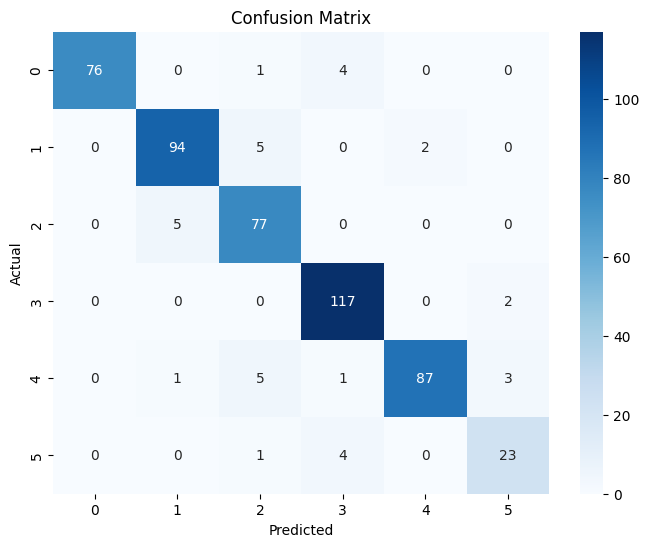

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(model, test_loader)

In [ ]:
waste_info = {
    'cardboard': {
        'recyclable': True,
        'reuse': True,
        'applications': [
            "Used for packaging (boxes, cartons)",
            "DIY projects and arts & crafts",
            "Compost material for gardening"
        ],
        'example_image': "https://hative.com/wp-content/uploads/2015/04/cool-homemade-cardboard-craft-ideas/1-cool-homemade-cardboard-craft-ideas.jpg"
    },
    'glass': {
        'recyclable': True,
        'reuse': True,
        'applications': [
            "Remelted into new glass products",
            "Upcycled into home décor (bottles, lamps)",
            "Used in construction (glasscrete, tiles)"
        ],
        'example_image': "https://pinklover.snydle.com/files/2016/04/DIY-Glass-Bottle-Craft-Ideas-1.jpg"
    },
    'metal': {
        'recyclable': True,
        'reuse': True,
        'applications': [
            "Repurposed into tools, car parts, and furniture",
            "Used in construction and manufacturing",
            "Melted for making new cans and wires"
        ],
        'example_image': "https://feltmagnet.com/.image/t_share/MTc0OTg2MjI3OTg5MjU1ODI0/18-cute-and-clever-tin-can-crafts.jpg"
    },
    'paper': {
        'recyclable': True,
        'reuse': True,
        'applications': [
            "Converted into recycled paper products",
            "Used for notebooks, tissues, newspapers",
            "Can be shredded for composting"
        ],
        'example_image': "https://tellloveandparty.com/wp-content/uploads/2020/03/DIY-PAPER-BUG-KID-CRAFT-1.jpg"
    },
    'plastic': {
        'recyclable': False,  # Some plastics can be recycled, but many aren't
        'reuse': False,
        'limitations': [
            "Contributes to ocean pollution & marine life harm",
            "Takes hundreds of years to degrade",
            "Releases toxic chemicals when burned"
        ],
        'example_image': "https://feltmagnet.com/.image/t_share/MTc0OTg2MjI3OTg5MjU1ODI0/75-inspiring-craft-ideas-using-plastic-bottles.jpg"
    },
    'litter': {
        'recyclable': False,
        'reuse': False,
        'limitations': [
            "Causes environmental pollution",
            "Harms wildlife when ingested",
            "Encourages bacterial growth & disease spread"
        ]
    }
}

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

def show_image_from_url(image_url):
    try:
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))
        plt.imshow(img)
        plt.axis("off")
        plt.show()
    except Exception as e:
        print(f"⚠ Could not load image: {e}")

def get_waste_info(category):
    info = waste_info.get(category, {})
    if info.get('recyclable', False):
        response = f"♻ **Category:** {category.capitalize()} | **Recyclable ✅**\n"
        if info.get('reuse', False):
            response += "✨ **Can be Reused!**\n"
        response += "**Applications:**\n- " + "\n- ".join(info['applications'])

        # Show example image
        if 'example_image' in info:
            print(response)
            show_image_from_url(info['example_image'])
        else:
            print(response)
    else:
        response = f"🚫 **Category:** {category.capitalize()} | **Not Recyclable ❌**\n"
        response += "**Limitations/Disadvantages:**\n- " + "\n- ".join(info['limitations'])
        print(response)

In [ ]:
from PIL import Image
import torch
from torchvision import transforms

# Define Transform (Same as Training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def predict_and_suggest(image_path, model):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        output = model(image)
        _, predicted_class = torch.max(output, 1)

    category = list(waste_info.keys())[predicted_class.item()]
    get_waste_info(category)

# Example Usage
predict_and_suggest("/content/dataset/dataset-resized/test/cardboard/cardboard10.jpg", model)


♻ **Category:** Cardboard | **Recyclable ✅**
✨ **Can be Reused!**
**Applications:**
- Used for packaging (boxes, cartons)
- DIY projects and arts & crafts
- Compost material for gardening
⚠ Could not load image: cannot identify image file <_io.BytesIO object at 0x7b8ff4aaaa20>


In [ ]:
# Create 'models' directory if not exists
import os
import torch
os.makedirs("models", exist_ok=True)

# Save the trained model
torch.save(model.state_dict(), "models/rwc_net.pth")

print("✅ Model saved as 'models/rwc_net.pth'")

✅ Model saved as 'models/rwc_net.pth'


In [ ]:
from google.colab import files
files.download("models/rwc_net.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r dataset.zip dataset/

  adding: dataset/ (stored 0%)
  adding: dataset/dataset-resized/ (stored 0%)
  adding: dataset/dataset-resized/paper/ (stored 0%)
  adding: dataset/dataset-resized/train/ (stored 0%)
  adding: dataset/dataset-resized/train/paper/ (stored 0%)
  adding: dataset/dataset-resized/train/paper/paper119.jpg (deflated 6%)
  adding: dataset/dataset-resized/train/paper/paper261.jpg (deflated 5%)
  adding: dataset/dataset-resized/train/paper/paper410.jpg (deflated 1%)
  adding: dataset/dataset-resized/train/paper/paper558.jpg (deflated 0%)
  adding: dataset/dataset-resized/train/paper/paper514.jpg (deflated 1%)
  adding: dataset/dataset-resized/train/paper/paper403.jpg (deflated 2%)
  adding: dataset/dataset-resized/train/paper/paper387.jpg (deflated 5%)
  adding: dataset/dataset-resized/train/paper/paper20.jpg (deflated 0%)
  adding: dataset/dataset-resized/train/paper/paper451.jpg (deflated 1%)
  adding: dataset/dataset-resized/train/paper/paper8.jpg (deflated 1%)
  adding: dataset/dataset-resi

In [ ]:
from google.colab import files
files.download("dataset.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>